In [1]:
#ROAD STATUS RANDOMIZER
#Road damage classification approximated towards epicenter
def road_block(reinforced, flood_risk):
    
    #Set Status to be 1 (passable)
    status=1
    
    #SENSITIVITY PARAMETERS
    ##############################################################################################
    #Define params for sensitivity
    base_x=0.8
    base_ae=0.4
    retro_inc=0.8
    ##############################################################################################
    
    #Set base probability depending on road type
    if flood_risk=="X":
        base = base_x#Unsure about this
    else:
        base= base_ae
    
    #Define Threshold for being impassable based on reinforcement (make sure prob is never negative)
    probability_not_passable = max(base-retro_inc*reinforced,0) 
        
    #passable or not
    status = np.random.binomial(n = 1, p = (1-probability_not_passable))    
    
    return status

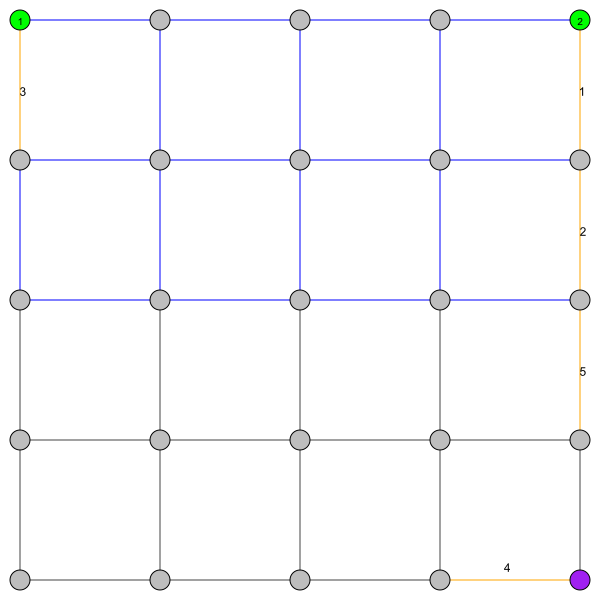

In [2]:
#CREATE GRAPH
#IMPORTANT: Need to install igraph and pycairo
#conda install -c marufr python-igraph
#conda install pycairo

#import packages
import igraph as ig
import numpy as np
import math

#Create Edgelist
edgelist=[]
floodlist=[]

#Use some for loop trickery to create network and assign flood zone
for i in range(5-1):
    for j in range(5):
        edgelist.append((5*j+i,5*j+i+1))
        if(j < 3):
            floodlist.append("X")
        else:
            floodlist.append("AE")
        
for i in range(5):
    for j in range(5-1):  
        edgelist.append((j*5+i,i+(j+1)*5))
        if(j < 2):
            floodlist.append("X")
        else:
            floodlist.append("AE")
        
#Create Graph From Edgelist
g=ig.Graph(edgelist)

#initialize graph attributes
pop_start=np.zeros(g.vcount())
evac_loc=np.zeros(g.vcount())
re_loc=np.zeros(g.ecount())
edge_weight=np.ones(g.ecount())
edge_labels=np.zeros(g.ecount(), dtype=np.int)

#DEFINE GRAPH VARIABLES
###############################################################################################################
#Choose Population Starting Points and Population Amounts
pop_start[0]=100
pop_start[4]=100

#Choose Evacuation Center
evac_loc[24]=1

#Choose Reinforcement and Priority (For graph visualization only)
#First
road_1=36
re_loc[road_1]=1
edge_labels[road_1]=1

#Second
road_2=37
re_loc[road_2]=1
edge_labels[road_2]=2

#Third
road_3=20
re_loc[road_3]=1
edge_labels[road_3]=3

#Fourth
road_4=19
re_loc[road_4]=1
edge_labels[road_4]=4

#Fifth
road_5=38
re_loc[road_5]=1
edge_labels[road_5]=5

################################################################################################################
#Assign Attributes
g.vs["pop"]=pop_start
g.vs["evac"]=evac_loc
g.es["reinforced"]=re_loc
g.es["weight"]=edge_weight
g.es["flood_risk"] = floodlist

#Count Number of Population Starting Points
population=pop_start[pop_start>0]
pop_start_no=len(population)

#Label Each Population
#allocate data
labels=np.zeros(len(pop_start),dtype=np.int)

#initialize index
lab_ind=1

#Loop over population starting points and label in increasing order (match output)
for i in range(len(pop_start)):
    if pop_start[i]>0:
        labels[i]=lab_ind
        lab_ind+=1
    else:
        labels[i]=0

#create labels
g.vs["label"]=labels
g.vs.select(label_eq=0)["label"]=""
g.vs["label_size"]=10

#Create Edge Labels
g.es["label"]=edge_labels
g.es.select(label_eq=0)["label"]=""
g.es.select(label_eq=989)["label"]=0

#Plot graph to see layout
#Default color of vertices is grey
g.vs["color"]="grey"

#Population Vertices are Green
g.vs.select(pop_gt=0)["color"]="green"

#Evac vertex is purple
g.vs.select(evac_eq=1)["color"]="purple"

#Reinforced Roads are Orange
g.es.select(flood_risk="X")["color"] = "blue"
g.es.select(reinforced_eq=1)["color"] = "orange"

#Set A Layout
layout = g.layout("grid")

#Graph
ig.plot(g, layout=layout)

In [6]:
#Save image if desired
out=ig.plot(g, layout=layout)
out.save('Road Choice Frequency.png')

In [3]:
#CALCULATE ACCESSIBILITY
def Evac_Access(g,trials,e_ind):
    
    #import
    import math
    
    #Create Vector for storing EC accessability for each starting point
    pop_reach=np.zeros(pop_start_no)
    Exp_Evac_Pop=np.zeros(trials)

    #Loop over number of trials
    for i in range(trials):
        
        #Create Copy of Graph for Disaster Test
        g_dis=g.copy()
        
        #Reinforce the requested road if index is positive
        if e_ind>=0:
            g_dis.es[e_ind]["reinforced"]=1

        #Delete Edges
        for e in g_dis.es:
            e["passable"]=road_block(e["reinforced"], e["flood_risk"])

        #delete edges
        g_dis.es.select(passable_eq=0).delete()

        #reset index of which population we are considering
        ind=0

        #See if there is a shortest route to EC for all population starting points
        for v in g_dis.vs.select(pop_gt=0):
            
            #Use Dijkstra's Algorithm to find shortest path distance, inf if there is no path
            dist=g_dis.shortest_paths_dijkstra(v,g_dis.vs.select(evac_eq=1),weights="weight")[0][0]

            if dist!=float('inf'):
                #If we can evacuate, update simulation statistics
                pop_reach[ind]=1                       
                
            #Increase Index
            ind+=1
            
        #Calculate and Store Important Statistic
        Exp_Evac_Pop[i]=sum(pop_reach*population)
        
        #Reset Whether a Population Reached Evac
        pop_reach=np.zeros(pop_start_no)
        
    #Calculate Statistics
    Mean=np.mean(Exp_Evac_Pop)
    Stderr=np.std(Exp_Evac_Pop, ddof=0)/math.sqrt(trials)
        
    #Return Statistics
    return (Exp_Evac_Pop)

In [12]:
##COMPUTE ACCESSIBILITY WITH EACH EDGE REINFORCED
#import 
import random
import math

#set random seed
random_seed=115
np.random.seed(random_seed)

#Define Variables for Sim
replications=2000

#reset all reinforcement
re_loc=np.zeros(g.ecount())

#REINFORCEMENT OPTIMIZATION
###########################################################################################
#Set Standard Reinforcement
#First
#re_loc[36]=1

#Second
#re_loc[37]=1

#Third
#re_loc[38]=1

#Fourth
#re_loc[39]=1

g.es["reinforced"]=re_loc
###########################################################################################

#Standard Sim
standard=Evac_Access(g,replications,-1)
#print(standard)

#Define Statistics Array
Expected_Evac_Total=np.zeros(g.ecount())
Z_Mean=np.zeros(g.ecount())
Z_err=np.zeros(g.ecount())

#Reinforce one road at a time
for e in g.es:
    
    #set random seed CRN
    np.random.seed(random_seed)
    
    #Run the above function with graph g, trials, and with the edge index to be reinforced
    sim_stats=Evac_Access(g,replications,e.index)
    
    #Use Sim_stats with standard to generate confidence intervals
    z=sim_stats-standard
    mean_z=np.mean(z)
    var_z=sum((z-mean_z)**2)/(replications*(replications-1))
    
    #Parse and store returned statistics    
    Expected_Evac_Total[e.index]=np.mean(sim_stats)
    Z_Mean[e.index]=mean_z
    Z_err[e.index]=math.sqrt(var_z)
    
#We can add a loop for policies here if we want

#Print Done so I know when it's stopped simulating
print("Done!")

Done!


In [13]:
##Print Results Here so the simulation doesn't have to be run every time
#import stats for CIs
from scipy.stats import t

#suppress sci
np.set_printoptions(suppress=True)

#vars
sig="No"

#Create Confidence Intervals
#Define Prob (Bonferroni Inequality for 40 CIs to obtain 95% confidence over all confidence intervals)
p=0.99875

#Calculate df
df=replications-1

#Get t crit score
t_crit = t.ppf((1+p)/2, df)

#Create All Confidence Intervals
Evac_CI=np.zeros([len(Z_Mean),2])
Evac_CI[:,0]=np.round(Z_Mean-Z_err*t_crit,5)
Evac_CI[:,1]=np.round(Z_Mean+Z_err*t_crit,5)

#Display Results 
print("Expected Evac Status Quo: ", np.mean(standard))
print("Expected Evac Total: ", Expected_Evac_Total)
print("Expected Z: ", Z_Mean)
print("Standard Error of Z: ", Z_err)
print("Ave Standard Err of Z: ", np.mean(Z_err))

#Find Best Road to Reinforce
max_loc=np.where(Expected_Evac_Total == np.amax(Expected_Evac_Total))
print("Best Road to Reinforce: ", max_loc[0])

#See if best is statistically significant
if Evac_CI[max_loc[0],0]>0:
    sig="Yes"
    
print("Statistically Significant?:", sig )
print("Maximum Evacuated Population: ", np.amax(Expected_Evac_Total))


print("T-crit:", t_crit)
print("Confidence Intervals:")
print(Evac_CI[:,:])

#print("Evacuation Percentages: ")
#print(evac_per)
#print("Expected Evacuations from each Population: ")
#print(Exp_evac_pp)

Expected Evac Status Quo:  4.6
Expected Evac Total:  [ 6.15  5.45  5.2   4.85  4.65  4.95  5.1   4.9   4.95  4.9   5.05  5.2
  5.05  4.95  5.2   6.4   6.6   5.65  5.3   5.9   8.9   7.85  5.15  4.8
  6.1   6.25  4.65  4.9   5.15  6.2   4.75  4.85  6.65  7.4   5.1   5.3
 12.9  12.65  5.75  6.15]
Expected Z:  [1.55 0.85 0.6  0.25 0.05 0.35 0.5  0.3  0.35 0.3  0.45 0.6  0.45 0.35
 0.6  1.8  2.   1.05 0.7  1.3  4.3  3.25 0.55 0.2  1.5  1.65 0.05 0.3
 0.55 1.6  0.15 0.25 2.05 2.8  0.5  0.7  8.3  8.05 1.15 1.55]
Standard Error of Z:  [0.27629137 0.20532859 0.17272787 0.11169148 0.05       0.13208889
 0.17288709 0.12232122 0.13208889 0.12232122 0.14969955 0.17272787
 0.14969955 0.13208889 0.18664785 0.29736209 0.31312781 0.22797969
 0.18647355 0.26303915 0.45371569 0.40286462 0.16541593 0.09992493
 0.27186753 0.29356744 0.05       0.12232122 0.17990256 0.28941645
 0.08655921 0.11169148 0.31693686 0.38229972 0.15775755 0.19943642
 0.61704568 0.60850957 0.23846841 0.29383996]
Ave Standard Err of

In [55]:
##Testing Area (Single Run of Above Method)
#import 
import random
import numpy as np

#Set random seed
random_seed=37

#set random seed non-CRN
np.random.seed(random_seed)

#Define Variables for Sim
rep=10000

#Standard
stan=Evac_Access(g,rep,-1)

#CRN
np.random.seed(random_seed)

#Test
test=Evac_Access(g,rep,39)
#print(standard)
#print(test)
print(np.mean(test-stan))
var_z=sum((test-stan)**2)/(rep*(rep-1))
print(var_z)

4.31
0.054105410541054104
